In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

C:\Users\sahar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
image_size = (224, 224)
batch_size = 64

train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "car_data",
    validation_split=0.15,
    subset="training",
    seed=1337,
    label_mode='int',
    # subset=None,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "car_data",
    validation_split=0.15,
    subset="validation",
    label_mode='int',
    seed=1337,
    # subset=None,
    image_size=image_size,
    batch_size=batch_size,
)




Found 13416 files belonging to 10 classes.
Using 11404 files for training.
Found 13416 files belonging to 10 classes.
Using 2012 files for validation.


In [3]:
x_train =[]
y_train = []
x_val =[]
y_val = []
for i, (image, label) in enumerate(train_ds.take(len(train_ds))):
    x_train.append(image)
    y_train.append(label)
for i, (image, label) in enumerate(val_ds.take(len(val_ds))):
    x_val.append(image)
    y_val.append(label)

x_train1 = []
for i in x_train:
    for j in i:
        x_train1.append(j)
x_train = np.array(x_train1)
y_train1 = []
for i in y_train:
    for j in i:
        y_train1.append(j)
# y_train = np.array(y_train1)
y_train = np.array(y_train1).reshape(11404,1)
x_val1 = []
for i in x_val:
    for j in i:
        x_val1.append(j)
x_val = np.array(x_val1)
y_val1 = []
for i in y_val:
    for j in i:
        y_val1.append(j)
# y_val = np.array(y_val1)

y_val = np.array(y_val1).reshape(2012,1)

print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 30
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 10  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

(2012, 224, 224, 3)
(2012, 1)
(11404, 224, 224, 3)
(11404, 1)


In [4]:
AUTO = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_ds = train_ds.shuffle(128).batch(64).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_ds = val_ds.batch(64).prefetch(AUTO)


In [5]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)

@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()
repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


In [6]:
x_train =[]
y_train = []
x_val =[]
y_val = []
x_train1 = []
y_train1 = []
y_val1 = []
x_val1 = []




# image_batch, label_batch = next(iter(pipeline_train))

# plt.figure(figsize=(10, 10))
# for n in range(25):
#     ax = plt.subplot(5, 5, n + 1)
#     plt.imshow(image_batch[n])
#     plt.title(label_batch[n].numpy())
#     plt.axis("off")

In [7]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)
learning_rate = 0.001 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, restore_best_weights=True
    )
]

In [13]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=7,
    steps_per_epoch=60,
    validation_data=pipeline_validation,
    # callbacks=train_callbacks,
)

Epoch 1/7
60/60 [==============================] - 862s 15s/step - loss: 0.8736 - accuracy: 0.6909 - val_loss: 1.0101 - val_accuracy: 0.6441
Epoch 2/7
60/60 [==============================] - 918s 15s/step - loss: 0.8199 - accuracy: 0.7018 - val_loss: 0.8793 - val_accuracy: 0.6670
Epoch 3/7
60/60 [==============================] - 918s 15s/step - loss: 0.8321 - accuracy: 0.7036 - val_loss: 0.8252 - val_accuracy: 0.7038
Epoch 4/7
60/60 [==============================] - 915s 15s/step - loss: 0.7432 - accuracy: 0.7352 - val_loss: 0.8485 - val_accuracy: 0.6933
Epoch 5/7
60/60 [==============================] - 916s 15s/step - loss: 0.7875 - accuracy: 0.7107 - val_loss: 0.8013 - val_accuracy: 0.7177
Epoch 6/7
60/60 [==============================] - 916s 15s/step - loss: 0.8417 - accuracy: 0.7005 - val_loss: 0.8436 - val_accuracy: 0.6938
Epoch 7/7
60/60 [==============================] - 917s 15s/step - loss: 0.7417 - accuracy: 0.7320 - val_loss: 0.7819 - val_accuracy: 0.7301


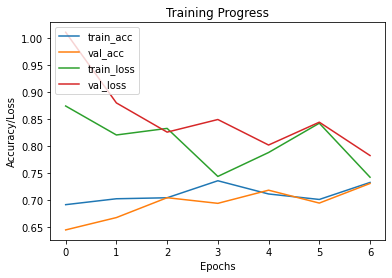

In [15]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [16]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

  4/118 [>.............................] - ETA: 1:07:16 - loss: 0.4405 - accuracy: 0.8516

In [14]:
model.save("model_cars3.tf")

INFO:tensorflow:Assets written to: model_cars3.tf\assets


INFO:tensorflow:Assets written to: model_cars3.tf\assets


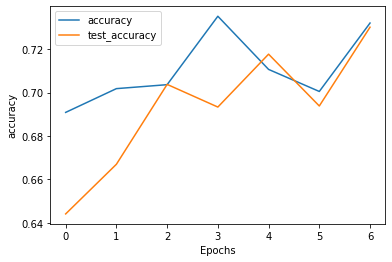

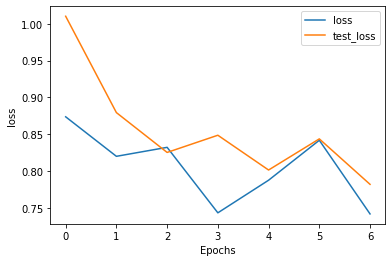

In [16]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'test_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")